In [1]:
import time
#time.sleep(60*60*8)

import numpy as np
from numpy import asarray
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.client import device_lib
import tensorflow.compat.v1.keras.backend as K
import tensorflow.compat.v1 as tf1

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
from skimage import data, color, img_as_ubyte ,io
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.color import rgb2gray,rgba2rgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,roc_auc_score,ConfusionMatrixDisplay
from sklearn.utils import class_weight
import imutils
import os
import random
from tqdm import tqdm
import urllib.request


tf.keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
strategy = tf.distribute.MirroredStrategy()

from classification_models.tfkeras import Classifiers
Resnext, preprocess_input = Classifiers.get('resnext50')

2024-03-21 10:06:18.446524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-03-21 10:06:19.184300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38223 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:85:00.0, compute capability: 8.0
2024-03-21 10:06:19.203490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38223 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:85:00.0, compute capability: 8.0


In [2]:

def to_categorical(y, num_classes=None, dtype='float32'):

 
    y = np.array(y, dtype='int')

    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.ravel()

    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]

    categorical = np.zeros((n, num_classes), dtype=dtype)

    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def label_smoothing(y, num_classes=5, dtype='float32', factor=0.2):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
         input_shape = tuple(input_shape[:-1])

    y = y.ravel()
    if not num_classes:
         num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1-factor
    for i in np.arange(n):
        if y[i]-1>=0 and y[i]+1<num_classes:
            categorical[i, y[i]-1] = factor/2
            categorical[i, y[i]+1] = factor/2
        elif y[i]-1>=0 and y[i]+1>=num_classes:
            categorical[i, y[i]-1] = factor
        else:
            categorical[i, y[i]+1] = factor
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical
        

In [337]:
#input 
fine= pd.read_csv('/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/fresh.csv')  
train=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_train_silver.csv")
test=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_test_gold_onlyGardnerScores.csv")

pixel=256
channels=3
NUM_CLASSES=5

fine_image=[]
fine_label=[]

train_image = []
train_label = []

test_image=[]
test_label=[]
testname=[]

for i in tqdm(range(fine.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/preprocess_rec/"+fine['image'][i]
    try:
        im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im,(pixel,pixel))
        im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
        img = img_to_array(im)
        fine_label.append(int(fine['g1'][i])-1)
        fine_image.append(img)
    except:
        print("fine:", filename)
        
for j in tqdm(range(train.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+train['Image'][j]
    if not train['g1'][j]=='NA':
        try:  
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            train_label.append(int(train['g1'][j])-1)
            train_image.append(img)
        except:
            print("train:", filename)
                
for k in tqdm(range(test.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
    if not test['g1'][k]=='NA':
        try:   
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            test_label.append(int(test['g1'][k])-1)
            test_image.append(img)
            testname.append(test['Image'][k])
        except:
            print("test:", filename)

 90%|██████████████████████████████████████████████▋     | 426/475 [00:01<00:00, 200.11it/s][ WARN:0@16044.431] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200402 CPK.bmp'): can't open/read file: check file path/integrity
[ WARN:0@16044.431] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp'): can't open/read file: check file path/integrity
[ WARN:0@16044.431] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp'): can't open/read file: check file path/integrity
[ WARN:0@16044.431] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg'): can't open/read file: check file path/integrity
100%|████████████████████████████████████████████████████| 475/475 [00:01<00:00, 267.59it/s]


fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200402 CPK.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg


 79%|█████████████████████████████████████████▎          | 238/300 [00:01<00:00, 121.93it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/607_06.png


100%|████████████████████████████████████████████████████| 300/300 [00:02<00:00, 125.89it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/833_02.png


In [338]:
#data augmentation    
a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]
a3= [x for x, y in list(enumerate(train_label)) if y ==3]
a4= [x for x, y in list(enumerate(train_label)) if y ==4]

print("before aug, a0:",len(a0))
print("before aug, a1:",len(a1))
print("before aug, a2:",len(a2))    
print("before aug, a3:",len(a3))
print("before aug, a4:",len(a4))
 
    
img0=[]
for i in a0:
    img0.append(train_image[i].astype(np.uint8))
img1=[]
for i in a1:
    img1.append(train_image[i].astype(np.uint8))
img2=[]
for i in a2:
    img2.append(train_image[i].astype(np.uint8))
img4=[]
for i in a4:
    img4.append(train_image[i].astype(np.uint8))



sometimes = lambda aug: iaa.Sometimes(0.5, aug)  
seq= iaa.Sequential([
    iaa.SomeOf((1, 3),
               [
    #iaa.ChangeColorTemperature((1100, 10000)),
    sometimes(iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.1))),
    iaa.GammaContrast((0.1)),
    iaa.MotionBlur(k=15),
    sometimes(iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))),
    iaa.Affine(
              translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
         ),
    iaa.pillike.EnhanceSharpness()
               ],
            random_order=True)
])

seq1=iaa.Sequential([
    iaa.SomeOf((2, 3),
               [
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.GammaContrast((0.1)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}), 
    iaa.pillike.EnhanceSharpness()],
            random_order=True)
])


img0_0 = seq(images=img0)
train_image.extend(img0_0)
for i in range(len(img0_0)):
    train_label.append(0)
    
img1_0 = seq(images=img1)
train_image.extend(img1_0)
for i in range(len(img1_0)):
    train_label.append(1)
    
img2_0 = seq(images=img2)
train_image.extend(img2_0)
for i in range(len(img2_0)):
    train_label.append(2)  
    
img4_0 = seq(images=img4)
train_image.extend(img4_0)
for i in range(len(img4_0)):
    train_label.append(4)
    
img4_1 = seq1(images=img4)
train_image.extend(img4_1)
for i in range(len(img4_1)):
    train_label.append(4)
    

a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]
a3= [x for x, y in list(enumerate(train_label)) if y ==3]
a4= [x for x, y in list(enumerate(train_label)) if y ==4]

print("after aug, a0:",len(a0))
print("after aug, a1:",len(a1))
print("after aug, a2:",len(a2))    
print("after aug, a3:",len(a3))
print("after aug, a4:",len(a4))

before aug, a0: 197
before aug, a1: 194
before aug, a2: 429
before aug, a3: 1081
before aug, a4: 143
after aug, a0: 394
after aug, a1: 388
after aug, a2: 858
after aug, a3: 1081
after aug, a4: 429


In [339]:
#preprocess input

xtrain = np.array(train_image,dtype='float32')  
ytrain = np.array(train_label)
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, ytrain, shuffle=True, random_state=42, test_size=0.15)

y_train= to_categorical(Y_train,5)
y_val=to_categorical(Y_val,5)

In [366]:
#model

def ordinal_loss(y_true,y_pred):
    #y_true = tf.cast(y_true, dtype=tf.int256)
    weights= K.cast(K.abs(K.argmax(y_true,axis=1)-K.argmax(y_pred,axis=1)),dtype='float32')
    return (1+weights)*tf.keras.losses.categorical_crossentropy(y_true,y_pred)


# vit_model = vit.vit_b16(
#         image_size = 224,
#         activation = 'linear',
#         pretrained = True,
#         include_top = True,
#         pretrained_top =True,)
#         #classes = 3)


# with strategy.scope():
resnext50 = Resnext((224, 224, 3),include_top=True, weights='imagenet')
model = Sequential([
        layers.Input(shape=(pixel,pixel,channels),name='main_input'),
        layers.Resizing(224, 224),
        layers.RandomRotation(factor=(-0.2, 0.3)),
        layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.BatchNormalization(),
        resnext50,
        layers.Dense(512, activation='tanh'),
        layers.Dense(5,activation='softmax'),
    ],
    name = 'resnext50_exp')

from keras import backend as K




opt = tf.keras.optimizers.Adam(learning_rate=0.00008)
model.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name='aucc')]) 

print(model.summary())


def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/ep{epoch:03d}_acc{val_accuracy:.4f}_val_loss{val_loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 10, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.8, min_lr=1e-6, patience=6, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

from sklearn.utils import class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=model.fit(X_train, y_train, batch_size= 32, validation_data=(X_val, y_val), epochs=80, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights)

Model: "resnext50_exp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_12 (Resizing)       (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_12 (RandomRo (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_12 (RandomFlip)  (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
model_12 (Functional)        (None, 1000)              25097137  
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 5005      
Total params: 25,102,154
Trainable params: 25,033,918
Non-trainable params: 68,236
____________________________________

In [ ]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    

In [ ]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))

file_dir="/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/"
def getepo(ep):
    file_dir="/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/"
    eps=[f for f in os.listdir(file_dir) if ep in f]
    eps.sort(key=lambda fn: os.path.getmtime(file_dir+fn) if not os.path.isdir(file_dir+fn) else 0)
    return eps[-1]

    

model.load_weights(file_dir+getepo('ep043'))
y_prediction=model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/model/'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [81]:
#finetune by HKU-QMH-CARE
ft_image=np.array((train_image+fine_image),dtype='float32')
ft_label=np.concatenate((to_categorical(train_label,5),label_smoothing(fine_label,5)),axis=0) #adopt label smoothing

index = [i for i in range(len(ft_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = ft_image[index]
y_fine = ft_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

ftmodel=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/model/8624161073825504.h5", compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
ftmodel.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 

print(model.summary())


def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.6, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=ftmodel.fit(X_fine, y_fine, batch_size=64, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_3 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
model_3 (Functional)         (None, 1000)              25097137  
_________________________________________________________________
dense_6 (Dense)              (None, 512)        

roc_auc_score: 0.9412249355348093
f1_score: 0.8713323209080105
accuracy_score: 0.87248322147651
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.77      0.74      0.75        31
           2       0.86      0.80      0.83        86
           3       0.91      0.95      0.93       153
           4       0.60      0.60      0.60         5

    accuracy                           0.87       298
   macro avg       0.79      0.79      0.79       298
weighted avg       0.87      0.87      0.87       298



/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


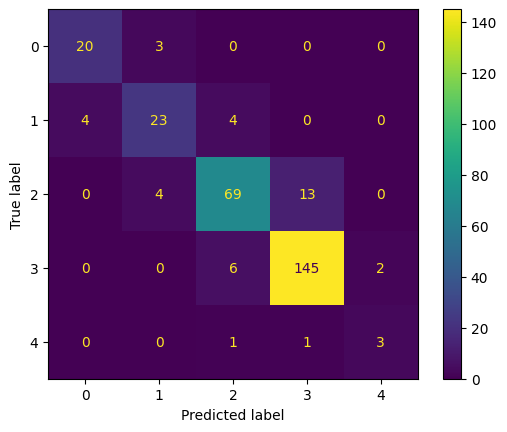

In [98]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))

y_prediction=ftmodel.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

ftmodel.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/model/ft_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [15]:
combine_image=np.array((train_image+fine_image),dtype='float32')
combine_label=np.concatenate((to_categorical(train_label,5),to_categorical(fine_label,5)),axis=0)  #without label smoothing

index = [i for i in range(len(combine_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = combine_image[index]
y_fine = combine_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

combine_model=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/model/8624161073825504.h5", compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
combine_model.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 

print(model.summary())


def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.6, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=combine_model.fit(X_fine, y_fine, batch_size=64, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

Model: "resnext50_exp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
model_1 (Functional)         (None, 1000)              25097137  
_________________________________________________________________
dense_2 (Dense)              (None, 512)             

roc_auc_score: 0.9427979777502357
f1_score: 0.8512113251141145
accuracy_score: 0.8523489932885906
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.71      0.71      0.71        31
           2       0.82      0.77      0.80        86
           3       0.91      0.93      0.92       153
           4       0.60      0.60      0.60         5

    accuracy                           0.85       298
   macro avg       0.77      0.78      0.78       298
weighted avg       0.85      0.85      0.85       298



/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


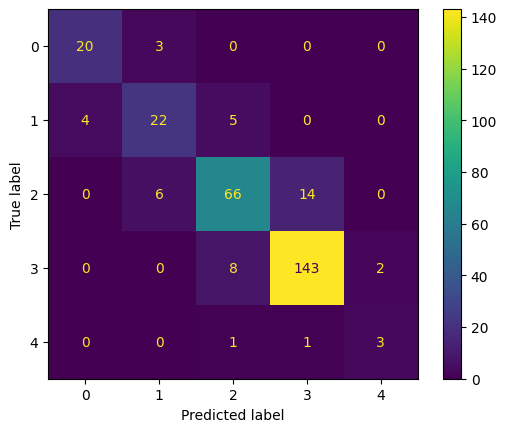

In [23]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))

y_prediction=combine_model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

combine_model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g1/model/cm_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()